In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageFont
from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('/content/drive/My Drive/Data/resize/X_80.pkl', 'rb') as fp:
  X_80 = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y = pickle.load(fp)

In [6]:
y = np.array(pd.get_dummies(y))

In [7]:
def get_classes(y):
  return [list(i).index(max(i)) for i in y]

In [8]:
classes = get_classes(y)
cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [9]:
# X_80 = [np.stack((img,)*3, axis=-1) for img in X_80]

In [10]:
X_80_train, X_80_test, y_train, y_test = train_test_split(X_80, y, test_size=int(len(y)*.15), random_state=42)
X_80_train, X_80_val, y_train, y_val = train_test_split(X_80_train, y_train, test_size=int(len(y)*.15), random_state=42)

In [11]:
print(len(X_80_train))
print(len(X_80_val))
print(len(X_80_test))

478426
102519
102519


In [12]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

478426
102519
102519


In [15]:
base_model = ResNet152V2(
    weights='imagenet',
    input_shape=(80,80,3),
    include_top=False)

for layer in base_model.layers[:-4]:
  layer.trainable=False

In [16]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 86, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 40, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 42, 42, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [17]:
inputs = keras.Input(shape=(80,80,3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 

x = keras.layers.Dense(10000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

x = keras.layers.Dense(5000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

x = keras.layers.Dense(1000)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x) 

outputs = keras.layers.Dense(514, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 3, 3, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10000)             20490000  
_________________________________________________________________
batch_normalization (BatchNo (None, 10000)             40000     
_________________________________________________________________
activation (Activation)      (None, 10000)            

In [19]:
history = model.fit(
    np.array([np.stack((img,)*3, axis=-1) for img in X_80_train]), 
    np.array(y_train), 
    epochs=30, 
    batch_size=512, 
    # class_weight=cw,
    validation_data=(np.array([np.stack((img,)*3, axis=-1) for img in X_80_val]), y_val))

Epoch 1/30
935/935 [==============================] - 212s 226ms/step - loss: 1.8967 - acc: 0.5781 - val_loss: 1.1738 - val_acc: 0.7065
Epoch 2/30
935/935 [==============================] - 209s 223ms/step - loss: 1.1384 - acc: 0.7101 - val_loss: 0.9178 - val_acc: 0.7633
Epoch 3/30
935/935 [==============================] - 209s 223ms/step - loss: 0.9533 - acc: 0.7491 - val_loss: 0.7900 - val_acc: 0.7917
Epoch 4/30
935/935 [==============================] - 209s 223ms/step - loss: 0.8392 - acc: 0.7749 - val_loss: 0.7262 - val_acc: 0.8075
Epoch 5/30
935/935 [==============================] - 209s 223ms/step - loss: 0.7599 - acc: 0.7922 - val_loss: 0.6967 - val_acc: 0.8142
Epoch 6/30
935/935 [==============================] - 209s 223ms/step - loss: 0.6942 - acc: 0.8073 - val_loss: 0.6416 - val_acc: 0.8287
Epoch 7/30
935/935 [==============================] - 209s 223ms/step - loss: 0.6407 - acc: 0.8197 - val_loss: 0.6196 - val_acc: 0.8331
Epoch 8/30
935/935 [============================

In [20]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

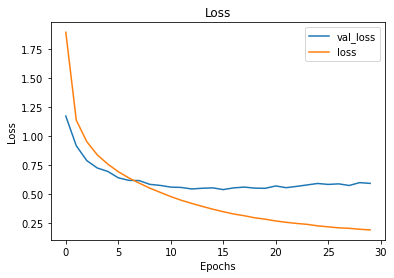

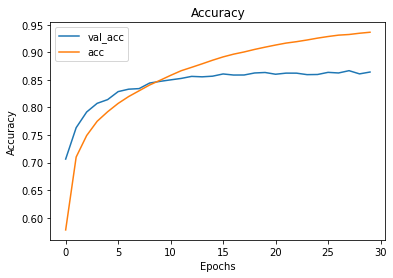

In [21]:
visualize_training_results(history)

In [22]:
print(classification_report(
    get_classes(y_test), 
    get_classes(model.predict(np.array([np.stack((img,)*3, axis=-1) for img in X_80_test])))
  )
)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.98      0.94      0.96       186
           2       0.74      0.41      0.52        69
           3       0.98      0.95      0.97       132
           4       0.85      0.87      0.86       358
           5       0.73      0.44      0.55        25
           6       0.61      0.59      0.60        39
           7       0.90      0.94      0.92       890
           8       0.93      0.96      0.95      1832
           9       0.91      0.91      0.91      1004
          10       0.79      0.71      0.75        96
          11       0.90      0.94      0.92       903
          12       0.83      0.87      0.85      2187
          13       0.89      0.92      0.91       947
          14       0.89      0.89      0.89      1147
          15       0.69      0.63      0.66        92
          16       0.87      0.89      0.88      1361
          17       0.71    